In [1]:
# importing libraries
import time
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

from prototype.logstic_regression import Logistic_Regression
from prototype.XGBoost import XGBoost
from prototype.naive_bayes import Naive_Bayes
from prototype.rnn import RNN
from prototype.cnn import CNN
from prototype.bert import BERT
from prototype.bilstm import BiLSTM

# Load the TextPreprocessor class (assumed to be defined already)
from textpreprocessor_rev2 import TextPreprocessor

import warnings
warnings.filterwarnings("ignore")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-10-12 21:34:13.012476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 21:34:13.021115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 21:34:13.023698: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 21:34:13.030272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 21:34:13.439786: W tensorflow/compiler/tf2

In [2]:
NUM_SAMPLE = 1000
TEST_RATIO=0.2
BATCH_SIZE=16
EPOCHS = 2
MAX_WORD_COUNT = 5000
MAX_LENGTH = 100
OUTPUT_DIR = "Output/proto_models_rev2_1000"

In [3]:
# Initialize the Text Preprocessor
processor = TextPreprocessor(MAX_WORD_COUNT, MAX_LENGTH)

# Load data
df_train, df_test = processor.parallel_load_data()

df_train_step1 = processor.remove_stopwords(df_train.copy())
df_test_step1 = processor.remove_stopwords(df_test.copy())

print('----------TRAIN DATA----------')
df_train_step2 = processor.filter_by_length_of_sentence(df_train_step1.copy(),50)
print('----------TEST DATA----------')
df_test_step2 = processor.filter_by_length_of_sentence(df_test_step1.copy(),50)

df_train_step3 = processor.sampling_data(df_train_step2, NUM_SAMPLE)
df_test_step3 = processor.sampling_data(df_test_step2, int(NUM_SAMPLE*TEST_RATIO))

# Preprocess data
df_train_step3 = processor.map_polarity(df_train_step3.copy())
df_test_step3 = processor.map_polarity(df_test_step3.copy())

# Split data
X_train, y_train = processor.split_data(df_train_step3)
X_test, y_test = processor.split_data(df_test_step3)

In [4]:
X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

01. Logistic Regression

In [5]:
logistic_regression = Logistic_Regression()
logistic_model = logistic_regression.train_model(X_train_tfidf, y_train)
y_pred_logistic = logistic_model.predict(X_test_tfidf)

02. XGBoost

In [6]:
xgboost = XGBoost()
xgb_model = xgboost.train_model(X_train_tfidf, y_train)

# Make predictions
y_pred_prob_xgb = xgb_model.predict(xgboost.convert_to_dmatrix(X_test_tfidf, y_test))
y_pred_xgb = [1 if prob > 0.5 else 0 for prob in y_pred_prob_xgb]

03. Naive Bayes

In [7]:
naive_bayes = Naive_Bayes()
nb_model = naive_bayes.train_model(X_train_tfidf, y_train)

# Making predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

04. Recurrent Neural Network

In [8]:
rnn = RNN(processor.max_features, processor.max_length, EPOCHS, 32)
rnn_model = rnn.train_model(X_train_pad, y_train, X_test_pad, y_test)

# Evaluate the model
y_pred_prob = rnn_model.predict(X_test_pad)
y_pred_rnn = (y_pred_prob > 0.5).astype("int32")

Epoch 1/2


I0000 00:00:1728761645.278572  277186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728761645.278627  277186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728761645.278644  277186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728761645.291596  277186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728761645.291667  277186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-12

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4569 - loss: 0.7106

I0000 00:00:1728761646.357458  277845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.4814 - loss: 0.7019 - val_accuracy: 0.5850 - val_loss: 0.6636
Epoch 2/2
 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7309 - loss: 0.5824

KeyboardInterrupt: 

05. Convolutional Neural Network

In [14]:
cnn = CNN(processor.max_features, processor.max_length, EPOCHS, 32)
cnn_model = cnn.train_model(X_train_pad, y_train, X_test_pad, y_test)


Epoch 1/2


TypeError: in user code:

    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1331, in apply_gradients
        tf.__internal__.smart_cond.smart_cond(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1329, in apply_fn
        return self._apply_gradients(grads, wrapped_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1361, in _apply_gradients
        self._optimizer.apply_gradients(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
        return self._update_step_xla(grad, var, id(self._var_key(var)))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in from_value
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in <genexpr>
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in from_value
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in <genexpr>
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 152, in from_value
        raise TypeError(

    TypeError: Python object could not be represented through the generic tracing type. Consider implementing the Tracing Protocol for it: <AutoCastVariable 'conv1d_3/kernel:0' shape=(5, 128, 128) dtype=float32 dtype_to_cast_to=float32>


In [15]:

# Evaluate the model
y_pred_prob = cnn_model.predict(X_test_pad)
y_pred_cnn = (y_pred_prob > 0.5).astype("int32")

7/7 [==============================] - 0s 5ms/step


06. Bidirectional Encoder Representations from Transformers(BERT)

In [16]:
from tensorflow.keras import mixed_precision

# Mixed Precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [17]:
bert = BERT(processor.max_features, 100, EPOCHS, int(32))
bert_model = bert.train_model(X_train, y_train, X_test, y_test)

# Predict on test data
y_pred_prob = bert_model.predict({'input_ids': bert.X_test_tokens['input_ids'], 'attention_mask': bert.X_test_tokens['attention_mask']}).logits
y_pred_bert = np.argmax(y_pred_prob, axis=-1)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


AttributeError: in user code:

    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/transformers/modeling_tf_utils.py", line 1630, in train_step
        x, y, sample_weight = keras.utils.unpack_x_y_sample_weight(data)

    AttributeError: module 'keras.utils' has no attribute 'unpack_x_y_sample_weight'


07. Bidirectional Long Short-Term Memory (BiLSTM)

In [18]:
X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

In [19]:
bilstm = BiLSTM(processor.tokenizer, EPOCHS, BATCH_SIZE)
bilstm_model = bilstm.train_model(X_train_pad, y_train, X_test_pad,y_test)

# Evaluate the model
y_pred_prob = bilstm_model.predict(X_test_pad)
y_pred_bilstm = (y_pred_prob > 0.5).astype("int32")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          365888    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              132000    
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               25728     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 523,745
Trainable params: 523,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


TypeError: in user code:

    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1331, in apply_gradients
        tf.__internal__.smart_cond.smart_cond(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1329, in apply_fn
        return self._apply_gradients(grads, wrapped_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/mixed_precision/loss_scale_optimizer.py", line 1361, in _apply_gradients
        self._optimizer.apply_gradients(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
        return self._update_step_xla(grad, var, id(self._var_key(var)))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in from_value
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in <genexpr>
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in from_value
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 129, in <genexpr>
        return default_types.Tuple(*(from_value(c, context) for c in value))
    File "/home/woong/AI/Dissertation/.venv/lib/python3.9/site-packages/tensorflow/core/function/trace_type/trace_type_builder.py", line 152, in from_value
        raise TypeError(

    TypeError: Python object could not be represented through the generic tracing type. Consider implementing the Tracing Protocol for it: <AutoCastVariable 'bidirectional/forward_lstm/lstm_cell_1/kernel:0' shape=(64, 400) dtype=float32 dtype_to_cast_to=float32>


In [19]:
# Dictionary to store the results
results = {
    'Model': [],
    'Training-Time':[],
    'Accuracy': [],
    'Precision (Class 0)': [],
    'Precision (Class 1)': [],
    'Recall (Class 0)': [],
    'Recall (Class 1)': [],
    'F1-Score (Class 0)': [],
    'F1-Score (Class 1)': []
}

# Function to calculate accuracy and classification report
def evaluate_model(model_class, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store the results
    results['Model'].append(model_class.model_name)
    results['Training-Time'].append(model_class.training_time)
    results['Accuracy'].append(accuracy)
    results['Precision (Class 0)'].append(report['0']['precision'])
    results['Precision (Class 1)'].append(report['1']['precision'])
    results['Recall (Class 0)'].append(report['0']['recall'])
    results['Recall (Class 1)'].append(report['1']['recall'])
    results['F1-Score (Class 0)'].append(report['0']['f1-score'])
    results['F1-Score (Class 1)'].append(report['1']['f1-score'])

# Call the function with your actual predictions (replace placeholders with your data)
evaluate_model(logistic_regression, y_test, y_pred_logistic)
evaluate_model(xgboost, y_test, y_pred_xgb)
evaluate_model(naive_bayes, y_test, y_pred_nb)
evaluate_model(rnn, y_test, y_pred_rnn)
evaluate_model(cnn, y_test, y_pred_cnn)
evaluate_model(bert, y_test, y_pred_bert)
evaluate_model(bilstm, y_test, y_pred_bilstm)

# Create a DataFrame from the results
df_results = pd.DataFrame(results)

# Create the directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save result to an Excel file
df_results.to_excel(os.path.join(OUTPUT_DIR, f'result(epoch{EPOCHS}_batch{BATCH_SIZE}_sample{NUM_SAMPLE}_ratio{TEST_RATIO}).xlsx'), index=False)

In [20]:
df_results

,Model,Training-Time,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1)
0,Logistic_Regression,0.024321,83.90,0.820426,0.853922,0.818589,0.855465,0.819507,0.854693
1,XGBoost,0.826344,78.80,0.758545,0.812443,0.770437,0.802168,0.764444,0.807273
2,Naive_Bayes,0.002842,81.95,0.827586,0.813973,0.752520,0.873532,0.788270,0.842702
3,RNN,30.425267,81.30,0.796571,0.825778,0.780515,0.839205,0.788462,0.832437
4,CNN,3.324620,81.30,0.796571,0.825778,0.780515,0.839205,0.788462,0.832437
5,BERT,162.082774,86.50,0.872162,0.859845,0.817469,0.903342,0.843931,0.881057
6,BiLSTM,28.700584,81.60,0.784399,0.843083,0.810750,0.820235,0.797357,0.831502


In [18]:
# Save Models
joblib.dump(logistic_model, os.path.join(OUTPUT_DIR, 'logistic_regression_model.pkl'))
joblib.dump(xgb_model, os.path.join(OUTPUT_DIR, 'xgboost_model.pkl'))
joblib.dump(nb_model, os.path.join(OUTPUT_DIR, 'naive_bayes_model.pkl'))
rnn_model.save(os.path.join(OUTPUT_DIR, 'rnn_model.h5'))  # or .tf
cnn_model.save(os.path.join(OUTPUT_DIR, 'cnn_model.h5'))
bert_model.save(os.path.join(OUTPUT_DIR, 'bert_model'), save_format='tf')
bilstm_model.save(os.path.join(OUTPUT_DIR, 'bilstm_model.h5'))

NameError: name 'bert_model' is not defined

In [19]:
joblib.dump(processor.tokenizer, os.path.join(OUTPUT_DIR, 'processor_tokenizer.pkl'))
joblib.dump(bert.X_train_tokens, os.path.join(OUTPUT_DIR, 'bert_X_train_tokens.pkl'))
joblib.dump(bert.X_test_tokens, os.path.join(OUTPUT_DIR, 'bert_X_test_tokens.pkl'))
joblib.dump(X_train_tfidf, os.path.join(OUTPUT_DIR, 'X_train_tfidf.pkl'))
joblib.dump(X_test_tfidf, os.path.join(OUTPUT_DIR, 'X_test_tfidf.pkl'))

joblib.dump(X_train_pad, os.path.join(OUTPUT_DIR, 'X_train_pad.pkl'))
joblib.dump(X_test_pad, os.path.join(OUTPUT_DIR, 'X_test_pad.pkl'))


['Output/proto_models_rev2_1000/bert_X_test_tokens.pkl']

In [31]:
import graphviz
print(graphviz.__version__)

0.20.3


<Figure size 200000x100000 with 0 Axes>

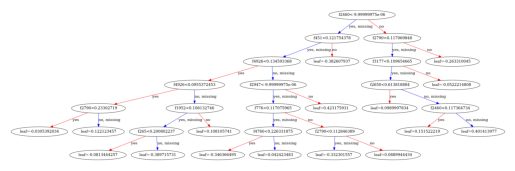

In [39]:
import matplotlib.pyplot as plt
from xgboost import plot_tree

# Plot a single tree from the XGBoost model
plt.figure(figsize=(20000, 100000))
plot_tree(xgb_model, num_trees=3)  # num_trees 인덱스를 변경하여 다른 트리 확인 가능
plt.show()

In [29]:
# Logistic Regression
print("Logistic Regression Parameters:", logistic_model.get_params())

# XGBoost
print("XGBoost Parameters:", xgb_model.())

# Naive Bayes
print("Naive Bayes Parameters:", naive_bayes.get_params())

Logistic Regression Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
XGBoost Parameters:       Tree  Node     ID Feature     Split    Yes     No Missing       Gain  \
0        0     0    0-0   f1961 -0.000010    0-1    0-2     0-1  62.085865   
1        0     1    0-1    f563 -0.000010    0-3    0-4     0-3  41.088654   
2        0     2    0-2    f451  0.121754    0-5    0-6     0-5   9.586075   
3        0     3    0-3   f1613 -0.000010    0-7    0-8     0-7  34.291237   
4        0     4    0-4    f652  0.088396    0-9   0-10     0-9   1.725901   
...    ...   ...    ...     ...       ...    ...    ...     ...        ...   
1627    99     8   99-8   f2658  0.166018   99-9  99-10   99-10   0.697337   
1628    99     9   99-9    Leaf       NaN

AttributeError: 'Naive_Bayes' object has no attribute 'get_params'

In [25]:
print(logistic_model)
print(xgb_model)
print(naive_bayes.model)
print(rnn.model.summary())
print(cnn.model.summary())
print(bert.model.summary())
print(bilstm.model.summary())

LogisticRegression()
MultinomialNB()
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 222, 128)          640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 652,417
Trainable params: 652,417
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 222, 128)          640000    
                                                    